# visualize_data

This script creates visualizations of a number of properties of the previously produced data.

In [1]:
# import required modules
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import statistics
from collections import Counter
import matplotlib.dates as mdates
from statannot import add_stat_annotation

In [2]:
# import table
mm = pd.read_csv('../data_tables/metadataMatrix_filtered.csv')
# mm

In [3]:
# define mode function for a list of items with two possible values...
# ...based on which is mentioned more, or 'Both' if score is equal
def getMode(items):
    try:
        r = statistics.mode(items)
    except:
        r = 'Both'
    return r

### Visualize by paper

Consider the data in units of PubMed publications.

In [4]:
fig_dims = (9, 6)

paps = mm[['pmc_ID', 'repository', 'reuse_role', 'pmc_date']]
paps = paps.groupby(['pmc_ID'], as_index = False).agg({'repository': lambda x: getMode(x), 
                                                       'reuse_role': lambda r: getMode(r),
                                                       'pmc_date': lambda d: max(d)})
# paps

In [5]:
# how many papers are in GEO, SRA, or both?
rc = Counter(paps['repository'])
repoCounts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
repoCounts.columns = ['repository', 'count']
repoCounts['percent'] = repoCounts['count'] / repoCounts['count'].sum()
repoCounts

repoCounts_T = repoCounts.T

cols = repoCounts_T.iloc[0, :]

repoCounts_T.columns = cols
repoCounts_T = repoCounts_T.iloc[2:,:]
# repoCounts_T

Text(0.5, 1.0, 'Percentage of papers mentioning each repository')

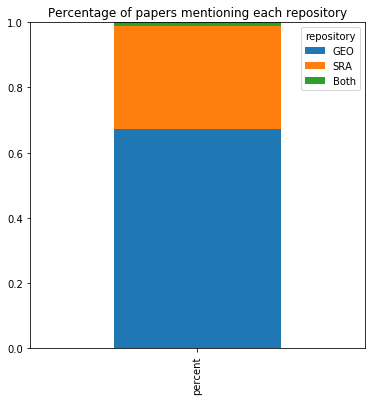

In [6]:
# visualize distribution of repositories mentioned by papers

ax = repoCounts_T.plot(kind = 'bar', stacked = True, figsize = (6, 6))
plt.ylim(0,1)
title = "Percentage of papers mentioning each repository"
ax.set_title(title)

In [7]:
# how many papers reuse, generate, or both?
recGEO = Counter(paps.loc[paps['repository'] == 'GEO', :]['reuse_role'])
reuseCountsGEO = pd.DataFrame.from_dict(recGEO, orient = 'index').reset_index()
reuseCountsGEO.columns = ['reuse_role', 'count']
reuseCountsGEO['percent'] = reuseCountsGEO['count'] / reuseCountsGEO['count'].sum()
# reuseCountsGEO

In [8]:
# how many papers reuse, generate, or both?
recSRA = Counter(paps.loc[paps['repository'] == 'SRA', :]['reuse_role'])
reuseCountsSRA = pd.DataFrame.from_dict(recSRA, orient = 'index').reset_index()
reuseCountsSRA.columns = ['reuse_role', 'count']
reuseCountsSRA['percent'] = reuseCountsSRA['count'] / reuseCountsSRA['count'].sum()
# reuseCountsSRA

In [9]:
rc = {'repository':['generating', 'reusing', 'both'], 
      'SRA':reuseCountsSRA['percent'], 
      'GEO':reuseCountsGEO['percent']}

reuseCounts = pd.DataFrame(data = rc).T
# cols = reuseCounts.iloc[0,:]
reuseCounts.columns = reuseCounts.iloc[0,:]
reuseCounts = reuseCounts.iloc[1:,:]
# reuseCounts

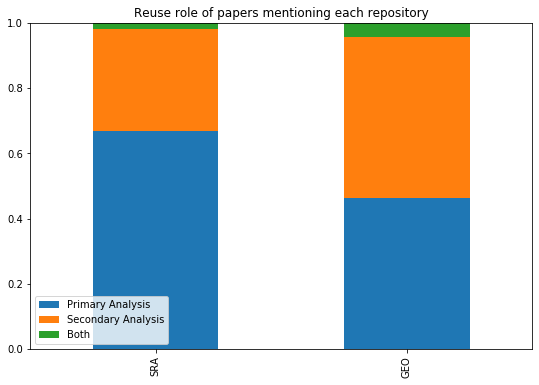

In [10]:
ax = reuseCounts.plot(kind = 'bar', stacked = True, figsize = fig_dims)
plt.ylim(0,1)
title = "Reuse role of papers mentioning each repository"
ax.set_title(title)
ax.legend(["Primary Analysis", "Secondary Analysis", "Both"])
plt.savefig("reuseRoleRepos.png")

In [11]:
# visualize reuse and repository distribution across the years
# add year column
fmt = '%Y-%m-%d'
paps.loc[:,'pmc_date'] = pd.to_datetime(paps['pmc_date'], format = fmt)
paps['year'] = paps['pmc_date'].dt.year
# paps

In [12]:
# get repository counts per date
repo_byDate = paps.groupby(['year', 'repository'])['repository'].count().to_frame(name = 'repo_count').reset_index()

# # merge reuse and repository tables
# by_date = pd.merge(repo_byDate, reuse_byDate, on = 'year', how = 'outer')
# by_date

In [13]:
dropme = repo_byDate[repo_byDate['year'] == 2020].index
repo_byDate.drop(dropme, inplace = True)

years = repo_byDate['year'].drop_duplicates().to_list()
years = [int(i) for i in years]

In [14]:
z = {'year':years, 'repository':'GEO', 'repo_count':0}
z2 = {'year':years, 'repository':'SRA', 'repo_count':0}
z3 = {'year':years, 'repository':'Both', 'repo_count':0}

zerosGEO = pd.DataFrame(data = z) #.append(pd.DataFrame(data = z2))
zerosSRA = pd.DataFrame(data = z2) #.append(pd.DataFrame(data = z4))
zerosBoth = pd.DataFrame(data = z3) #.append(pd.DataFrame(data = z6))

geo_byDate = repo_byDate.loc[repo_byDate['repository'] == 'GEO', :].append(zerosGEO).groupby(['year']).sum().reset_index().cumsum()
sra_byDate = repo_byDate.loc[repo_byDate['repository'] == 'SRA', :].append(zerosSRA).groupby(['year']).sum().reset_index().cumsum()
bothRepo_byDate = repo_byDate.loc[repo_byDate['repository'] == 'Both', :].append(zerosBoth).groupby(['year']).sum().reset_index().cumsum()

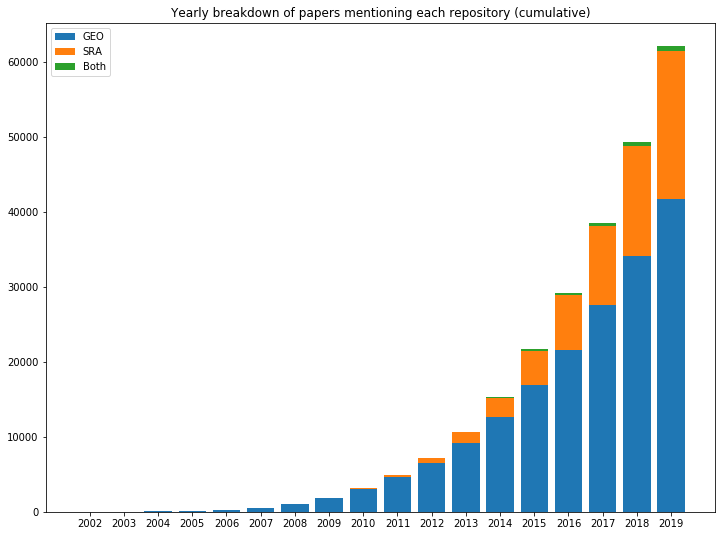

In [15]:
fig, ax = plt.subplots(figsize = (12, 9))

plt.bar(years, geo_byDate['repo_count'])
plt.bar(years, sra_byDate['repo_count'], 
        bottom = geo_byDate['repo_count'])
plt.bar(years, bothRepo_byDate['repo_count'], 
        bottom = [i+j for i, j in zip(geo_byDate['repo_count'], sra_byDate['repo_count'])])

plt.xticks(ticks = years)
title = "Yearly breakdown of papers mentioning each repository (cumulative)"
plt.title(title)
plt.legend(["GEO", "SRA", "Both"], loc = 'upper left')
plt.show()

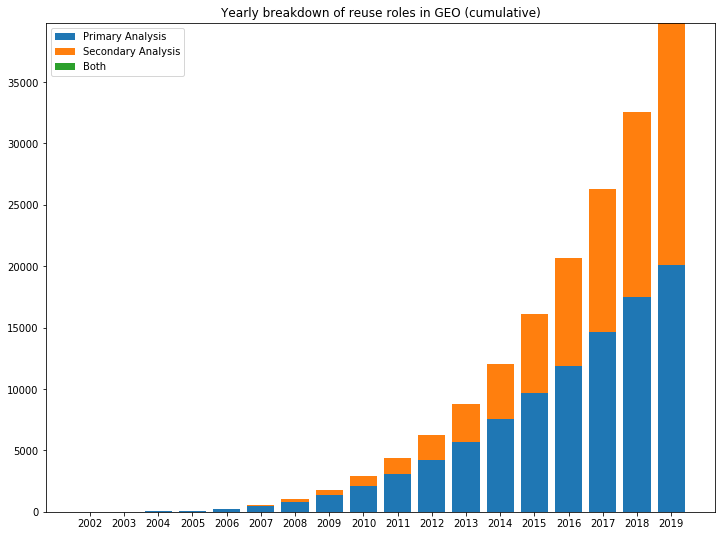

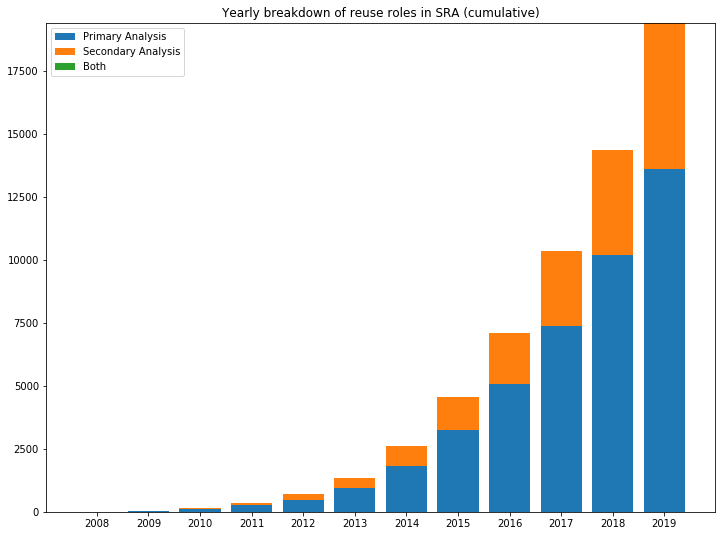

In [51]:
# get reuse counts per date

# CUMULATIVE
reuse_byDateGEO = paps.loc[paps['repository'] == 'GEO', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()
reuse_byDateSRA = paps.loc[paps['repository'] == 'SRA', :].groupby(['year', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()

timesthru = 0
for reuse_byDate in [reuse_byDateGEO, reuse_byDateSRA]:
    
    dropme = reuse_byDate[reuse_byDate['year'] == 2020].index
    reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}
    z3 = {'year':years, 'reuse_role':'Both', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)
    zerosBoth = pd.DataFrame(data = z3)

    R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index().cumsum()
    G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index().cumsum()
    bothReuse_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'Both', :].append(zerosBoth).groupby(['year']).sum().reset_index().cumsum()

    fig, ax = plt.subplots(figsize = (12, 9))

    plt.bar(years, G_byDate['reuse_count'])
    plt.bar(years, R_byDate['reuse_count'], 
            bottom = G_byDate['reuse_count'])
    plt.bar(years, bothReuse_byDate['reuse_count'], 
            bottom = [i+j for i, j in zip(G_byDate['reuse_count'], R_byDate['reuse_count'])])

    if timesthru == 0:
        repo = 'GEO'
    else:
        repo = 'SRA'
        
    plt.xticks(ticks = years)
    title = "Yearly breakdown of reuse roles in " + str(repo) + " (cumulative)"
    plt.title(title)
    plt.legend(["Primary Analysis", "Secondary Analysis", "Both"], loc = 'upper left')
    filename = "cumTimeSer_" + repo + ".png"
    plt.savefig(filename)
    plt.show()
    
    timesthru = 1

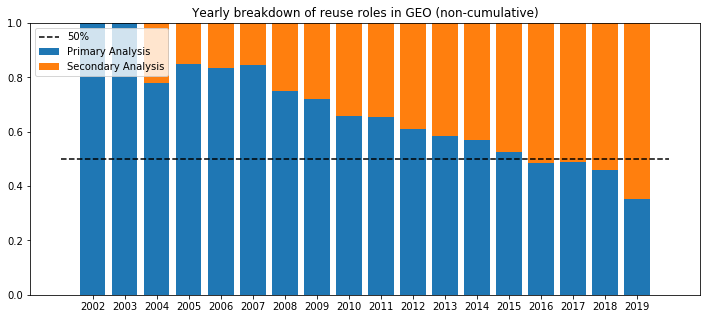

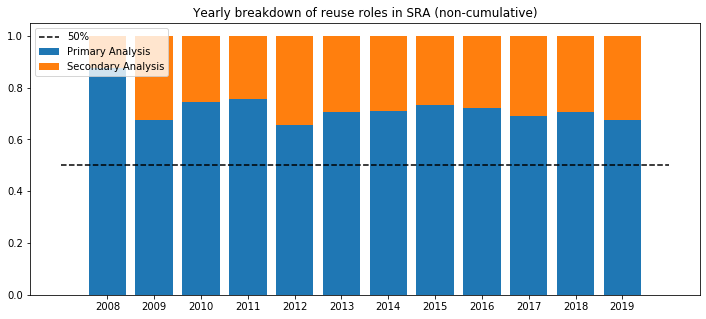

In [50]:
# NON-CUMULATIVE
timesthru = 0
for reuse_byDate in [reuse_byDateGEO, reuse_byDateSRA]:
    
    dropme = reuse_byDate[reuse_byDate['year'] == 2020].index
    reuse_byDate.drop(dropme, inplace = True)

    years = reuse_byDate['year'].drop_duplicates().to_list()

    z = {'year':years, 'reuse_role':'G', 'reuse_count':0}
    z2 = {'year':years, 'reuse_role':'R', 'reuse_count':0}
#     z3 = {'year':years, 'reuse_role':'Both', 'reuse_count':0}

    zerosG = pd.DataFrame(data = z)
    zerosR = pd.DataFrame(data = z2)
#     zerosBoth = pd.DataFrame(data = z3)

    R_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'R', :].append(zerosG).groupby(['year']).sum().reset_index()
    G_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'G', :].append(zerosR).groupby(['year']).sum().reset_index()
#     bothReuse_byDate = reuse_byDate.loc[reuse_byDate['reuse_role'] == 'Both', :].append(zerosBoth).groupby(['year']).sum().reset_index()
    
    fig, ax = plt.subplots(figsize = (12, 5))
    
    total_counts = G_byDate['reuse_count'] + R_byDate['reuse_count'] # + bothReuse_byDate['reuse_count']
    plt.bar(years, G_byDate['reuse_count'] / total_counts)
    plt.bar(years, R_byDate['reuse_count'] / total_counts, 
            bottom = G_byDate['reuse_count'] / total_counts)
#     plt.bar(years, bothReuse_byDate['reuse_count'] / total_counts, 
#             bottom = [i+j for i, j in zip(G_byDate['reuse_count'] / total_counts, 
#                                           R_byDate['reuse_count'] / total_counts)])
    
    if timesthru == 0:
        repo = 'GEO'
        plt.plot([2001, 2020], [0.5, 0.5], '--', color = 'black')
    else:
        repo = 'SRA'
        plt.plot([2007, 2020], [0.5, 0.5], '--', color = 'black')
        
    plt.xticks(ticks = years)
    title = "Yearly breakdown of reuse roles in " + str(repo) + " (non-cumulative)"
    plt.title(title)
#     plt.legend(["50%", "Primary Analysis", "Secondary Analysis", "Both"], loc = 'upper left')
    plt.legend(["50%", "Primary Analysis", "Secondary Analysis"], loc = 'upper left')
    filename = "nonCumTimeSer_" + repo + ".png"
    plt.savefig(filename)
    plt.show()
    
    timesthru = 1

In [47]:
# remove papers with 'Both' listed for either repository or reuse_role
paps = paps.loc[paps['repository'] != 'Both', :].loc[paps['reuse_role'] != 'Both', :]
# paps

In [19]:
# # across GEO and SRA, what percentage of papers reuse data?
# reuse_pcts = paps.copy()
# reuse_pcts['is_reuser'] = (reuse_pcts['reuse_role'] == 'R')

# reuse_pcts = reuse_pcts.groupby('repository', as_index = False).agg({'is_reuser' : 'mean'})
# reuse_pcts = reuse_pcts.rename(columns = {'is_reuser':'pctReusing'})
# # reuse_pcts

In [20]:
# # plot percentage of papers mentioning each repository that reuse data
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.barplot(data = reuse_pcts, x = 'repository', y = 'pctReusing', ax = ax)
# plt.ylim(0,1)
# title = "Percentage of papers that reused data"
# plt.title(title)
# plt.show()

### Visualize by dataset

Consider the data in units of SRA and GEO datasets.

In [21]:
# how many times is each dataset used?
# take the slice we need from mm
accs = mm[['converted_accession', 'repository', 'reuse_count', 'time_public']].drop_duplicates()
# accs['reuse_count'] = accs['total_use_count'] - 1
# accs

In [22]:
# what percentage of datasets are used more than once (re-used at least once)?
accs['wasReused'] = accs['reuse_count'] * accs['time_public'] >= 1
accsPcts = accs.groupby('repository', as_index = False).agg({'wasReused':'mean'})
accsPcts = accsPcts.rename(columns = {'wasReused':'pctReused'})
# accsPcts

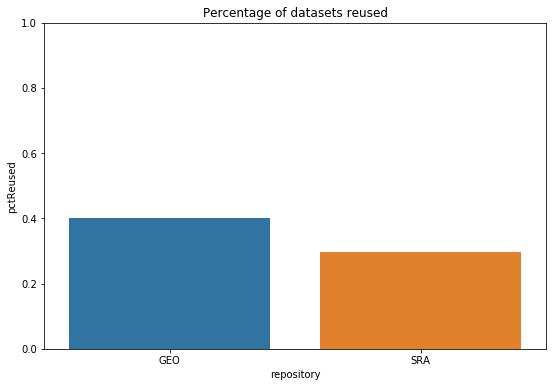

In [23]:
# plot barplot showing percentage of datasets reused in GEO and SRA
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = accsPcts, x = 'repository', y = 'pctReused', ax = ax)
plt.ylim(0,1)
title = "Percentage of datasets reused"
ax.set_title(title)
plt.show()

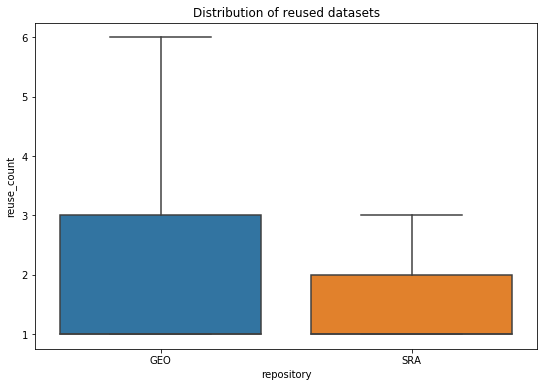

In [52]:
# plot distribution of use for each unique dataset, first using a boxplot
# each point is a dataset

# remove datasets not reused at all
accs_filt = accs.loc[accs['reuse_count'] > 0, :]

fig, ax = plt.subplots(figsize=fig_dims)
datasets_box = sns.boxplot(data = accs_filt, x = 'repository', y = 'reuse_count', showfliers = False, ax = ax)
# datasets_box.set(yscale = 'log')
title = "Distribution of reused datasets"
ax.set_title(title)
plt.savefig("reuseDistRepos.png")
plt.show()

In [25]:
# # visualize reuse distribution with a strip plot (jitter plot)
# fig, ax = plt.subplots(figsize=fig_dims)
# datasets_strip = sns.stripplot(data = accs_filt, x = 'repository', y = 'reuse_count', ax = ax)
# title = "Distribution of reused datasets"
# ax.set_title(title)
# # datasets_strip.set(yscale = 'log')

### Visualize by feature

Consider the data in units of each dataset's reuse count.

In [26]:
mm_filt = pd.merge(paps, mm, how = 'left', on = ['pmc_ID', 'repository', 'reuse_role'])
# mm_filt

In [27]:
accs_feat = mm_filt.drop(labels = ['pmc_ID', 'accession', 'pmc_date_x'], axis = 1).drop_duplicates()
accs_feat = accs_feat.rename(columns = {'pmc_date_y' : 'pmc_date'})
# accs_feat['reuse_count'] = (accs_feat['total_use_count'] - 1)
# accs_feat

In [28]:
def inList(pot_vec, ref_vec):
    bools = []
    for i in pot_vec:
        if(type(i) == str):
            if(i in ref_vec):
                bools.append(True)
            else:
                bools.append(False)
        else:
            bools.append(False)
    return bools

In [29]:
# plot reuse per species

sc = Counter(accs_feat['species'])

specCounts = pd.DataFrame.from_dict(sc, orient = 'index').reset_index()
specCounts.columns = ['species', 'count']

accs_feat['is_human'] = accs_feat['species'] == 'Homo sapiens'

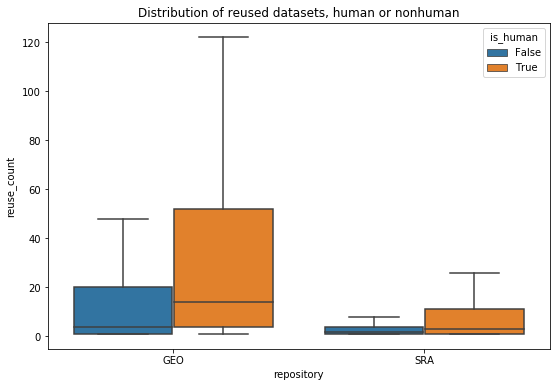

In [53]:
fig, ax = plt.subplots(figsize=fig_dims)
# sns.boxenplot(data = accs_feat.loc[accs_feat['reuse_count'] > 0, :], 
#               x = 'repository', y = 'reuse_count', hue = 'is_human', ax = ax).set(yscale = 'log')
sns.boxplot(data = accs_feat.loc[accs_feat['reuse_count'] > 0, :], 
              x = 'repository', y = 'reuse_count', hue = 'is_human', showfliers = False, ax = ax)
title = "Distribution of reused datasets, human or nonhuman"
ax.set_title(title)
plt.savefig("reuseDistHuman.png")
plt.show()

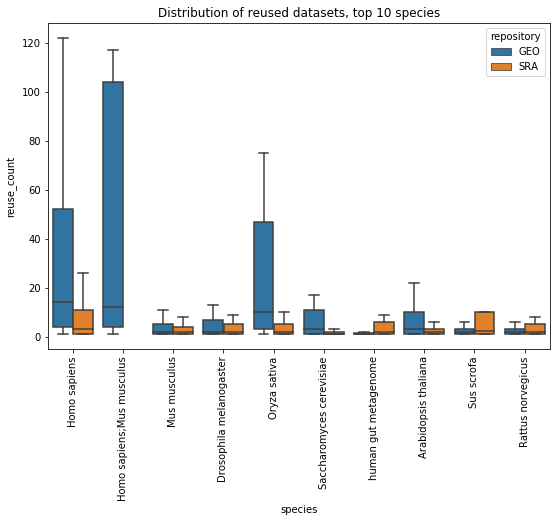

In [31]:
# plot reuse distribution for top 10 species

NUM_TOPSPECIES = 10

topSpec = specCounts.dropna().sort_values(by = 'count', ascending = False).head(n = NUM_TOPSPECIES)['species'].to_list()
            
accs_top_spec = accs_feat.loc[inList(accs_feat['species'], topSpec), :].sort_values(by = 'reuse_count', ascending = False)

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'reuse_count', hue = 'repository', showfliers = False, ax = ax)
# s.set(yscale = 'log')
# add_stat_annotation(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :],
#                    x = 'species', y = 'reuse_count',
#                     box_pairs = [(("Homo sapiens", "GEO"), ("Homo sapiens"), ("SRA"))], test = 't-test_ind', ax = ax)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPSPECIES) + " species"
ax.set_title(title)
plt.show()

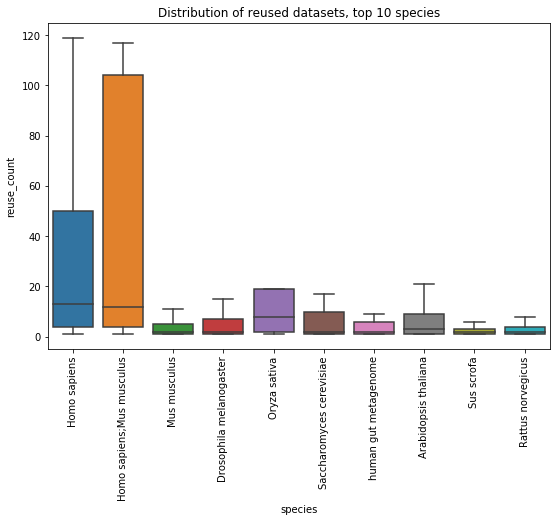

In [32]:
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_spec.loc[accs_top_spec['reuse_count'] > 0, :], 
                x = 'species', y = 'reuse_count', showfliers = False, ax = ax)
# s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPSPECIES) + " species"
ax.set_title(title)
plt.show()

In [33]:
# plot reuse per library strategy in SRA

lc = Counter(accs_feat.loc[accs_feat['repository'] == "SRA", :]['library_strategy'])

libCounts = pd.DataFrame.from_dict(lc, orient = 'index').reset_index()
libCounts.columns = ['library_strategy', 'count']
# print(specCounts.head(n = 20))

NUM_TOPLIBS = 10

topLibsSRA = libCounts.dropna().sort_values(by = 'count', ascending = False).head(n = NUM_TOPLIBS)['library_strategy'].to_list()

accs_top_libsSRA = accs_feat.loc[inList(accs_feat['library_strategy'], topLibsSRA), :].sort_values(by = 'reuse_count', ascending = False)

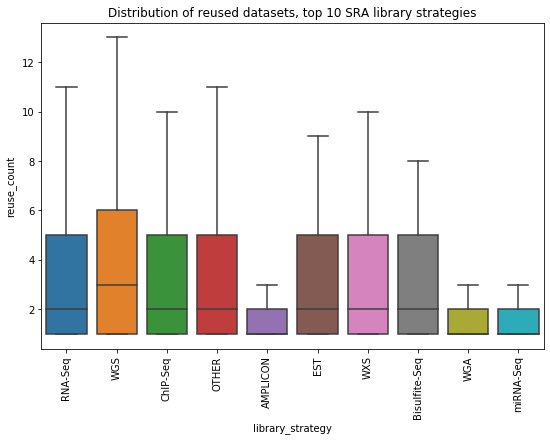

In [34]:
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_libsSRA.loc[accs_top_libsSRA['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'reuse_count', showfliers = False, ax = ax)
# s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPLIBS) + " SRA library strategies"
ax.set_title(title)
plt.show()

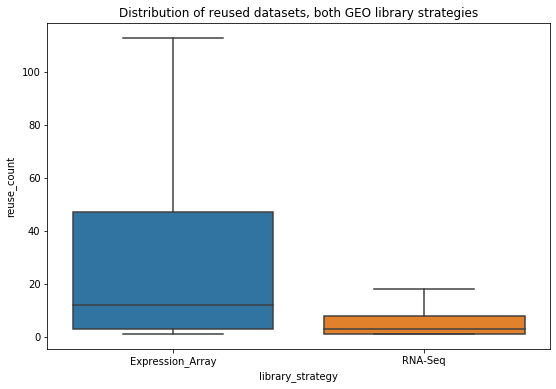

In [35]:
# plot reuse per library strategy in GEO

accs_top_libsGEO = accs_feat.loc[accs_feat['repository'] == 'GEO', :]

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxplot(data = accs_top_libsGEO.loc[accs_top_libsGEO['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'reuse_count', showfliers = False, ax = ax)
# s.set(yscale = 'log')
title = "Distribution of reused datasets, both GEO library strategies"
ax.set_title(title)
plt.show()

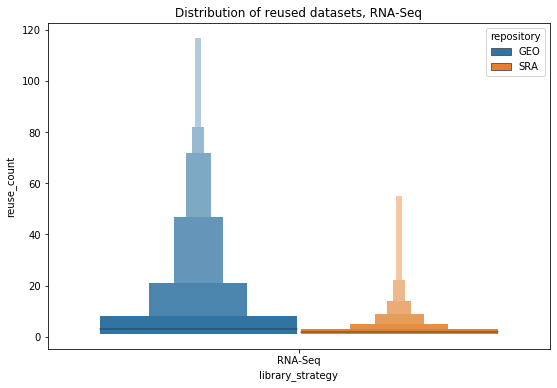

In [36]:
# plot library stragegy overlap between SRA and GEO (RNA-Seq)

accsRS = accs_feat.loc[accs_feat['library_strategy'] == 'RNA-Seq', :]

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.boxenplot(data = accsRS.loc[accsRS['reuse_count'] > 0, :], 
                x = 'library_strategy', y = 'reuse_count', hue = 'repository', ax = ax)
# s.set(yscale = 'log')
title = "Distribution of reused datasets, RNA-Seq"
ax.set_title(title)
plt.show()

In [37]:
# plot reuse per hardware

hc = Counter(accs_feat['hardware'])

hwCounts = pd.DataFrame.from_dict(hc, orient = 'index').reset_index()
hwCounts.columns = ['hardware', 'count']

NUM_TOPHWS = 15

topHws = hwCounts.dropna().sort_values(by = 'count', ascending = False).head(n = NUM_TOPHWS)['hardware'].to_list()

accs_top_hws = accs_feat.loc[inList(accs_feat['hardware'], topHws), :].sort_values(by = 'reuse_count', ascending = False)

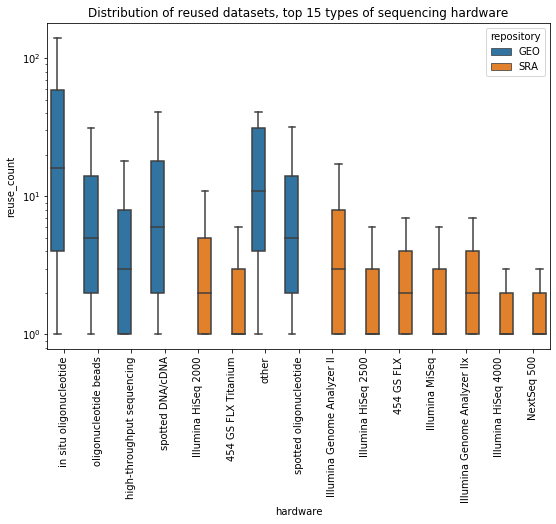

In [38]:
fig, ax = plt.subplots(figsize=fig_dims)
# s = sns.boxenplot(data = accs_top_hws.loc[accs_top_hws['reuse_count'] > 0, :], x = 'hardware', y = 'reuse_count', hue = 'repository', ax = ax)
s = sns.boxplot(data = accs_top_hws.loc[accs_top_hws['reuse_count'] > 0, :], 
                x = 'hardware', y = 'reuse_count', hue = 'repository', showfliers = False, ax = ax)
s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets, top " + str(NUM_TOPHWS) + " types of sequencing hardware"
ax.set_title(title)
plt.show()

In [39]:
# plot reuse by impact factor

# import data
if_table = pd.read_csv("../data_tables/impactFactor_table.csv")
if_table = if_table.drop(['journal', 'pmc_ID'], axis = 1).drop_duplicates().dropna()
avgIFs = if_table.groupby('converted_accession', as_index = False).agg({'ImpactFactor':'max'})
if_table = pd.merge(avgIFs, if_table, on = 'converted_accession', how = 'left')
if_table = if_table.rename(columns = {'ImpactFactor_x':'MAX_ImpactFactor', 'ImpactFactor_y':'ImpactFactor'})
# if_table

In [40]:
if_table = if_table.drop(['ImpactFactor'], axis = 1).drop_duplicates()
# if_table

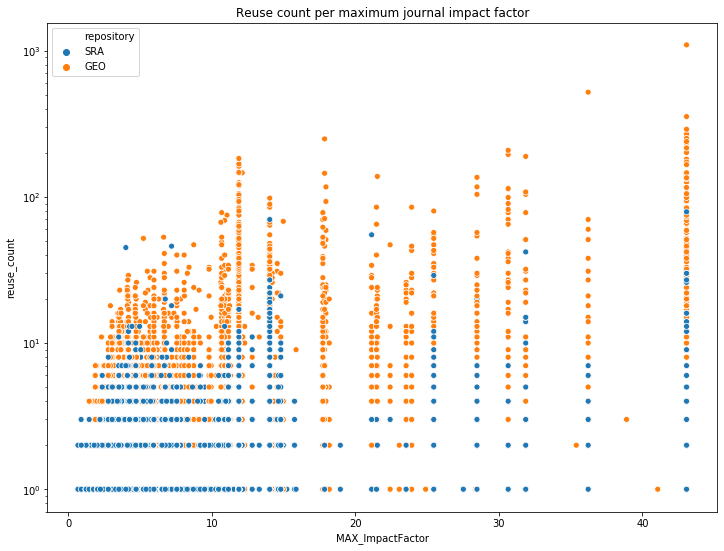

In [41]:
fig, ax = plt.subplots(figsize=(12, 9))
s = sns.scatterplot(data = if_table.loc[if_table['reuse_count'] > 0, :], x = 'MAX_ImpactFactor', y = 'reuse_count', hue = 'repository', ax = ax)
s.set(yscale = 'log')
title = "Reuse count per maximum journal impact factor"
ax.set_title(title)
plt.show()

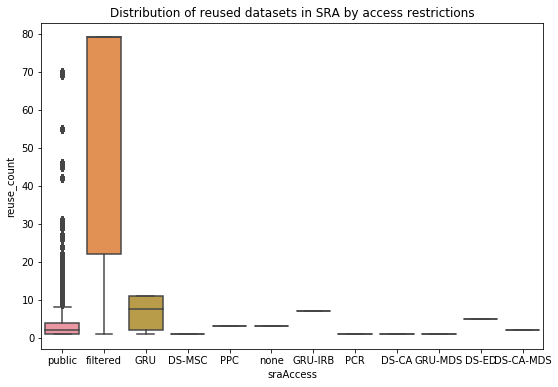

In [42]:
# plot reuse by access restrictions

# Counter(accs_feat.loc[accs_feat['repository'] == 'SRA', :]['sraAccess'])

fig, ax = plt.subplots(figsize=fig_dims)
# sns.boxenplot(data = accs_feat.loc[accs_feat['repository'] == 'SRA', :].loc[accs_feat['reuse_count'] > 0], x = 'sraAccess', y = 'reuse_count', ax = ax)
sns.boxplot(data = accs_feat.loc[accs_feat['repository'] == 'SRA', :].loc[accs_feat['reuse_count'] > 0], x = 'sraAccess', y = 'reuse_count', ax = ax)
s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
title = "Distribution of reused datasets in SRA by access restrictions"
ax.set_title(title)
plt.show()

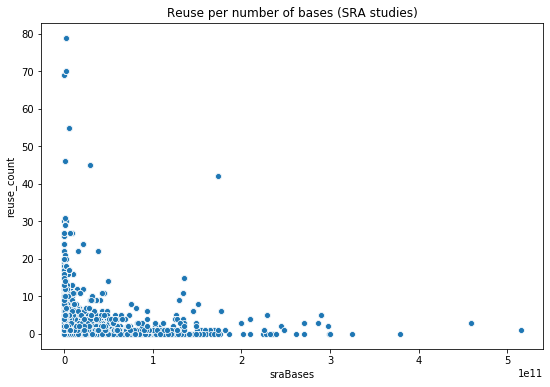

In [43]:
# plot reuse versus sample size

fig, ax = plt.subplots(figsize=fig_dims)
s = sns.scatterplot(data = accs_feat, x = 'sraBases', y = 'reuse_count')
title = "Reuse per number of bases (SRA studies)"
ax.set_title(title)
plt.show()

In [44]:
# determine the top 10 most reused datasets

NUM_MOSTREUSED = 10

most_reused = accs_feat[['converted_accession', 'reuse_count']].drop_duplicates().sort_values(by = 'reuse_count', ascending = False).head(n = NUM_MOSTREUSED)
most_reused

,converted_accession,reuse_count
848,GPL570,1095
484,GPL96,520
591,GSE2034,354
1238,GSE7390,290
155,GSE1456,269
686,GSE3494,251
15265,GSE31210,249
1267,GSE6532,239
16611,GSE14520,234
41,GSE506,216
